In [ ]:
# This is the analysis notebook for the first submission of the VOGM 4D flow manuscript
# Jeff Stout, Boston Children's Hospital
# 2023/09/21

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import json
import nibabel as nib
import nilearn
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy
import scipy.io
import nilearn.image
import nilearn.glm
import nilearn.plotting
import statsmodels.stats.multitest

In [2]:
T = pd.read_csv('VOGM_4dflowdata.csv')

T['SSMD'] = T['SS-MD']
T['SSA'] = T['SS-A']
T['inflow_ml/min'] = T['Inflow']*60
T['age_at_scan_weeks'] = T['age_at_scan_months']* (52/12)

# Don't always have SSS from the same technqiue
T['SSS'] = T['SSS_pre_2dpcmri']
T.loc[1, 'SSS'] =  T.loc[1, 'SSS_pre_4dflow']
T.loc[4, 'SSS'] =  T.loc[4, 'SSS_pre_4dflow']
T.loc[11, 'SSS'] =  T.loc[11, 'SSS_pre_4dflow']
T.loc[15, 'SSS'] =  T.loc[15, 'SSS_pre_4dflow']

T = T.reset_index()

In [3]:
# There are two groups here and the embo for some definitely affects flow
# the slopes are about the same, different intercepts, none signficant.
# Joint modeling would be possible.

T_noembo = T[T.embo == 0].reset_index(drop=True)


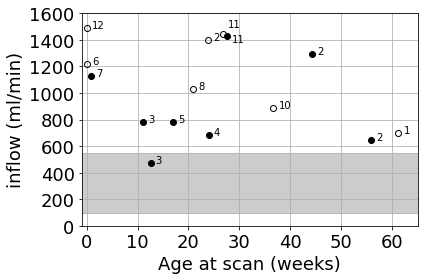

In [4]:
##### Figure 3a
# Inflow versus GA. This is really abnormal
# So this is an interesting plot when compared with the normal data that goes from 100ml/min at birth to 550ml/min at 60 weeks (ref: Varela, Liu)
# plt.plot(T['age_at_scan_weeks'], T['inflow_ml/min'], 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'inflow_ml/min'], 'ko', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'inflow_ml/min'], 'ko')
plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('inflow (ml/min)', fontsize=18)
plt.ylim([0, 1600])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
ax = plt.gca()
ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# for i, x in enumerate(T['SS-MD']):
#     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['inflow_ml/min'][i]+0.1)))
    
for i, x in enumerate(T['ID_N']):
    if x != 11:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, (T['inflow_ml/min'][i])))
for i, x in enumerate(T['ID_N']):
    if x == 11 and i == 11:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, (T['inflow_ml/min'][i])+50))
    if x == 11 and i == 12:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, (T['inflow_ml/min'][i])-50))

fig = plt.gcf()
plt.tight_layout()
# fig.savefig('fig3a.png')  

In [5]:
# Inflow models for paper
T['inflow_ml_min'] = T['inflow_ml/min']
mod = smf.ols(formula="inflow_ml_min ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
mod = smf.ols(formula="inflow_ml_min ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())
mod = smf.ols(formula="inflow_ml_min ~ age_at_scan_weeks + embo + NAR", data=T)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          inflow_ml_min   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.010
Date:                Thu, 21 Sep 2023   Prob (F-statistic):              0.332
Time:                        12:43:47   Log-Likelihood:                -118.16
No. Observations:                  16   AIC:                             240.3
Df Residuals:                      14   BIC:                             241.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1230.1925    174.59

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [6]:
# What is cortical flow? something like the inflow - varix flow
T['cortical_flow'] = (T['Inflow'] - T['falcine'])*60
# Or it could be SSS flow before the falcine drainage
T['SSS_mlmin'] = T['SSS'] * 60

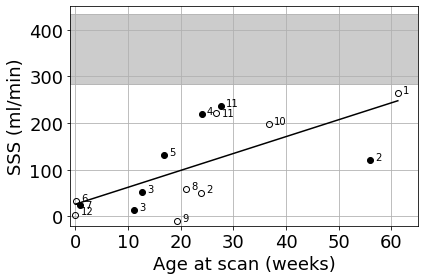

In [7]:
## SSS versus GA. Fig 2d

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'SSS_mlmin'], 'ko', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'SSS_mlmin'], 'ko')
plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('SSS (ml/min)', fontsize=18)
plt.ylim([-20, 300])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

# Trendline
T_nan = T.dropna(subset=['SSS']) # This wasn't plotting, becasue of nan in the SSS column
d = np.polyfit(T_nan['age_at_scan_weeks'], T_nan['SSS_mlmin'], 1)
f = np.poly1d(d)
plot_x = [np.min(T_nan['age_at_scan_weeks']), np.max(T_nan['age_at_scan_weeks'])]
plt.plot(plot_x, f(plot_x), 'k-')

ax = plt.gca()
# ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# for i, x in enumerate(T['SS-MD']):
#     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['SSS'][i]+0.1)*60))
for i, x in enumerate(T['ID_N']):
    if x == 7: # move it down a bit
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['SSS_mlmin'][i]-6))
    elif x == 11 and i == 11:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['SSS_mlmin'][i]-6))
    else:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['SSS_mlmin'][i]))

# SSS from Can Wu
sss_data = pd.read_excel('Vessel Blood Flow Can Wu 2017.xlsx', header=3)
# plt.plot(52 * sss_data.loc[sss_data['Age [Y]']<1.6, 'Age [Y]'], 60 * sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'], 'kx')
# plt.xlim([-1, 70])
plt.ylim([-20, 450])
ax.axhspan(np.min(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, np.max(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, alpha=0.2, color='black')
        
fig = plt.gcf()
plt.tight_layout()
# fig.savefig('fig2d.png')

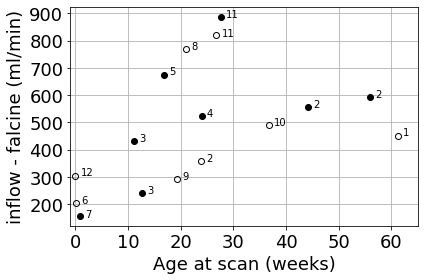

In [8]:
## Inflow-flacine versus GA. fig 2c

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'cortical_flow'], 'ko', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'cortical_flow'], 'ko')
plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('inflow - falcine (ml/min)', fontsize=18)
# plt.ylim([-20, 300])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

# # Trendline
# T_nan = T.dropna(subset=['SSS']) # This wasn't plotting, becasue of nan in the SSS column
# d = np.polyfit(T_nan['age_at_scan_weeks'], T_nan['cortical_flow'], 1)
# f = np.poly1d(d)
# plt.plot(T_nan['age_at_scan_weeks'], f(T_nan['age_at_scan_weeks']), 'k-')

ax = plt.gca()
# ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# for i, x in enumerate(T['SS-MD']):
#     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['SSS'][i]+0.1)*60))
for i, x in enumerate(T['ID_N']):
    if x == 7: # move it down a bit
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['cortical_flow'][i]-6))
    elif x == 11 and i == 11:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['cortical_flow'][i]-6))
    else:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['cortical_flow'][i]))

        
fig = plt.gcf()
plt.tight_layout()
# fig.savefig('fig2c.png')

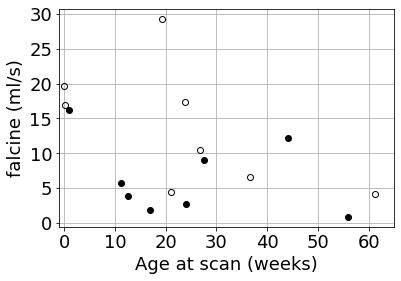

In [11]:
## Inflow-flacine versus GA

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'falcine'], 'ko', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'falcine'], 'ko')
plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('falcine (ml/s)', fontsize=18)
# plt.ylim([-20, 300])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()


In [12]:
# Falcine models

T['falcine_mlmin'] = T['falcine'] * 60

mod = smf.ols(formula="falcine_mlmin ~ SSMD", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())


mod = smf.ols(formula="falcine_mlmin ~ SSMD + embo", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())


mod = smf.ols(formula="falcine_mlmin ~ SSMD + embo + NAR", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())

mod = smf.ols(formula="falcine_mlmin ~ age_at_scan_weeks", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())

mod = smf.ols(formula="falcine_mlmin ~ age_at_scan_weeks +embo", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          falcine_mlmin   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     11.52
Date:                Thu, 21 Sep 2023   Prob (F-statistic):            0.00436
Time:                        12:52:17   Log-Likelihood:                -116.07
No. Observations:                  16   AIC:                             236.1
Df Residuals:                      14   BIC:                             237.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -186.3894    250.380     -0.744      0.4

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-pac

In [10]:
## A bit more about cortical flow:
mod = smf.ols(formula="cortical_flow ~ age_at_scan_weeks + embo + NAR", data=T)
res = mod.fit()
print(res.summary())

mod = smf.ols(formula="SSS_mlmin ~ age_at_scan_weeks + embo + NAR", data=T)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          cortical_flow   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     2.151
Date:                Tue, 19 Sep 2023   Prob (F-statistic):              0.147
Time:                        15:55:35   Log-Likelihood:                -105.25
No. Observations:                  16   AIC:                             218.5
Df Residuals:                      12   BIC:                             221.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           499.9858    138.60

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [249]:
## SSS 
mod = smf.ols(formula="SSS_mlmin ~ age_at_scan_weeks", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())


## So relating falcine flow to SSMD including a categorical effect of embolizaiton works really well without Labady, and with him still looks alright
mod = smf.ols(formula="SSS_mlmin ~ age_at_scan_weeks + embo", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())


## Probably a stretch, but nearly significant
mod = smf.ols(formula="SSS_mlmin ~ age_at_scan_weeks + embo + NAR", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              SSS_mlmin   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     11.38
Date:                Thu, 07 Sep 2023   Prob (F-statistic):            0.00499
Time:                        11:42:44   Log-Likelihood:                -84.530
No. Observations:                  15   AIC:                             173.1
Df Residuals:                      13   BIC:                             174.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            26.3734     30.60

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


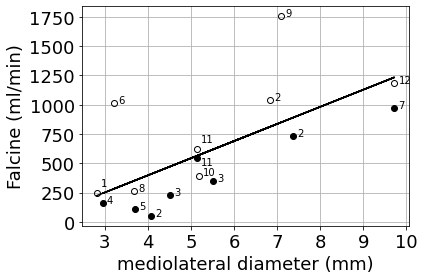

In [23]:
### Figure 2b
# Falcince:Inflow versus SS-MD. This is really abnormal
# So this is an interesting plot when compared with the normal data that goes from 100ml/min at birth to 550ml/min at 60 weeks (ref: Varela, Liu)
# abstract style, all solid
# plt.plot(T['SS-MD'], T['falcine']*60, 'ko')

# # No red/black for NAR, ALL Black
# # No NAR is black
# plt.plot(T.loc[(T['embo']==0) , 'SS-MD'], T.loc[(T['embo']==0) , 'falcine']*60, 'ko', fillstyle='none',)
# plt.plot(T.loc[(T['embo']==1) , 'SS-MD'], T.loc[(T['embo']==1) , 'falcine']*60, 'ko')

# No NAR is black
plt.plot(T.loc[(T['embo']==0) & (T['NAR']==0), 'SS-MD'], T.loc[(T['embo']==0) & (T['NAR']==0), 'falcine']*60, 'ko', fillstyle='none',)
plt.plot(T.loc[(T['embo']==1) & (T['NAR']==0), 'SS-MD'], T.loc[(T['embo']==1) & (T['NAR']==0), 'falcine']*60, 'ko')
# NAR is red
# plt.plot(T.loc[(T['embo']==0) & (T['NAR']==1), 'SS-MD'], T.loc[(T['embo']==0) & (T['NAR']==1), 'falcine']*60, 'ro', fillstyle='none',)
# plt.plot(T.loc[(T['embo']==1) & (T['NAR']==1), 'SS-MD'], T.loc[(T['embo']==1) & (T['NAR']==1), 'falcine']*60, 'ro')
plt.plot(T.loc[(T['embo']==0) & (T['NAR']==1), 'SS-MD'], T.loc[(T['embo']==0) & (T['NAR']==1), 'falcine']*60, 'ko', fillstyle='none',)
plt.plot(T.loc[(T['embo']==1) & (T['NAR']==1), 'SS-MD'], T.loc[(T['embo']==1) & (T['NAR']==1), 'falcine']*60, 'ko')

plt.xlabel('mediolateral diameter (mm)', fontsize=18)
plt.ylabel('Falcine (ml/min)', fontsize=18)
# plt.ylim([0, 300])
# plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
d = np.polyfit(T['SS-MD'], T['falcine']*60, 1)
f = np.poly1d(d)
plt.plot(T['SS-MD'], f(T['SS-MD']), 'k-')
 
for i, x in enumerate(T['ID_N']):
    if i == 0:
        plt.annotate('%i' % x, (T['SS-MD'][i]+.1, (T['falcine'][i]+1)*60))
    elif i == 11:
        plt.annotate('%i' % x, (T['SS-MD'][i]+.1, (T['falcine'][i]+1)*60))
    elif i == 12:
        plt.annotate('%i' % x, (T['SS-MD'][i]+.1, (T['falcine'][i]-1)*60))
    else:
        plt.annotate('%i' % x, (T['SS-MD'][i]+.1, T['falcine'][i]*60))

# # M.W. second time point
# plt.plot(4.52, 3.8, 'ko', fillstyle='none')
# plt.annotate('3', (4.52+0.1, 3.8+0.1))

fig = plt.gcf()
plt.tight_layout()
# fig.savefig('fig2d.png')

In [396]:
## I would really like to know how the MCA/PCA ratio looks

In [13]:
# Now that you have PCA flows, calc the ratio
T.keys()
T['R_PCAMCA'] = T['RPCA'] / T['RMCA']
T['L_PCAMCA'] = T['LPCA'] / T['LMCA']

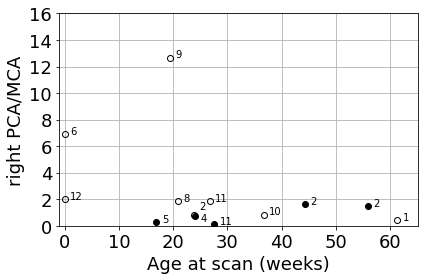

In [14]:
## RPCMCA versus GA. 

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'R_PCAMCA'], 'ko', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'R_PCAMCA'], 'ko')
plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('right PCA/MCA', fontsize=18)
plt.ylim([0, 16])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

# # Trendline
# T_nan = T.dropna(subset=['SSS']) # This wasn't plotting, becasue of nan in the SSS column
# d = np.polyfit(T_nan['age_at_scan_weeks'], T_nan['SSS_mlmin'], 1)
# f = np.poly1d(d)
# plot_x = [np.min(T_nan['age_at_scan_weeks']), np.max(T_nan['age_at_scan_weeks'])]
# plt.plot(plot_x, f(plot_x), 'k-')

# ax = plt.gca()
# # ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# for i, x in enumerate(T['SS-MD']):
#     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['SSS'][i]+0.1)*60))
for i, x in enumerate(T['ID_N']):
    if i == 1: # move it down a bit
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['R_PCAMCA'][i] + 0.4))
    elif i == 4: # move it down a bit
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['R_PCAMCA'][i] - 0.4))
    else:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['R_PCAMCA'][i]))

# # SSS from Can Wu
# sss_data = pd.read_excel('Vessel Blood Flow Can Wu 2017.xlsx', header=3)
# # plt.plot(52 * sss_data.loc[sss_data['Age [Y]']<1.6, 'Age [Y]'], 60 * sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'], 'kx')
# # plt.xlim([-1, 70])
# plt.ylim([-20, 450])
# ax.axhspan(np.min(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, np.max(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, alpha=0.2, color='black')
        
fig = plt.gcf()
plt.tight_layout()
fig.savefig('fig_rmcamca.png')

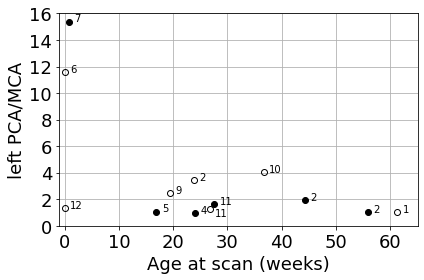

In [15]:
## LPCMCA versus GA. 

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'L_PCAMCA'], 'ko', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'L_PCAMCA'], 'ko')
plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('left PCA/MCA', fontsize=18)
plt.ylim([0, 16])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

# # Trendline
# T_nan = T.dropna(subset=['SSS']) # This wasn't plotting, becasue of nan in the SSS column
# d = np.polyfit(T_nan['age_at_scan_weeks'], T_nan['SSS_mlmin'], 1)
# f = np.poly1d(d)
# plot_x = [np.min(T_nan['age_at_scan_weeks']), np.max(T_nan['age_at_scan_weeks'])]
# plt.plot(plot_x, f(plot_x), 'k-')

# ax = plt.gca()
# # ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# for i, x in enumerate(T['SS-MD']):
#     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['SSS'][i]+0.1)*60))
for i, x in enumerate(T['ID_N']):
    if i == 11: # move it down a bit
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]-0.5))
    elif x == 11 and i == 11:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]))
    else:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]))

# # SSS from Can Wu
# sss_data = pd.read_excel('Vessel Blood Flow Can Wu 2017.xlsx', header=3)
# # plt.plot(52 * sss_data.loc[sss_data['Age [Y]']<1.6, 'Age [Y]'], 60 * sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'], 'kx')
# # plt.xlim([-1, 70])
# plt.ylim([-20, 450])
# ax.axhspan(np.min(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, np.max(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, alpha=0.2, color='black')
        
fig = plt.gcf()
plt.tight_layout()
fig.savefig('fig_lmcamca.png')

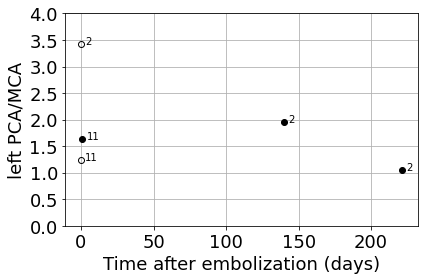

In [16]:
### PCA/MCA versus time after embo

# Falcine versus day of embo.
# So this is an interesting plot when compared with Wu et al. 2016

T_plot = T.loc[(T['ID_N']==2) | (T['ID_N']==11)].reset_index(drop=True)

plt.plot(T_plot.loc[T_plot['embo']==0, 'embo_time_days'], T_plot.loc[T_plot['embo']==0, 'L_PCAMCA'], 'ko', fillstyle='none',)
plt.plot(T_plot.loc[T_plot['embo']==1, 'embo_time_days'], T_plot.loc[T_plot['embo']==1, 'L_PCAMCA'], 'ko')

plt.xlabel('Time after embolization (days)', fontsize=18)
plt.ylabel('left PCA/MCA', fontsize=18)
plt.ylim([0, 4])
# plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(axis="both")

ax1 = plt.gca()
for i, x in enumerate(T_plot['ID_N']):
    ax1.annotate('%i' % x, (T_plot['embo_time_days'][i]+3, (T_plot['L_PCAMCA'][i])))


fig = plt.gcf()
plt.tight_layout()
fig.savefig('fig_embolizationtimeLmcamca.png')

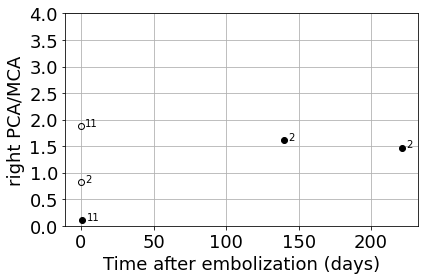

In [17]:
# Falcine versus day of embo.
# So this is an interesting plot when compared with Wu et al. 2016

T_plot = T.loc[(T['ID_N']==2) | (T['ID_N']==11)].reset_index(drop=True)

plt.plot(T_plot.loc[T_plot['embo']==0, 'embo_time_days'], T_plot.loc[T_plot['embo']==0, 'R_PCAMCA'], 'ko', fillstyle='none',)
plt.plot(T_plot.loc[T_plot['embo']==1, 'embo_time_days'], T_plot.loc[T_plot['embo']==1, 'R_PCAMCA'], 'ko')

plt.xlabel('Time after embolization (days)', fontsize=18)
plt.ylabel('right PCA/MCA', fontsize=18)
plt.ylim([0, 4])
# plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(axis="both")

ax1 = plt.gca()
for i, x in enumerate(T_plot['ID_N']):
    ax1.annotate('%i' % x, (T_plot['embo_time_days'][i]+3, (T_plot['R_PCAMCA'][i])))


fig = plt.gcf()
plt.tight_layout()
fig.savefig('fig_embolizationtimeRmcamca.png')

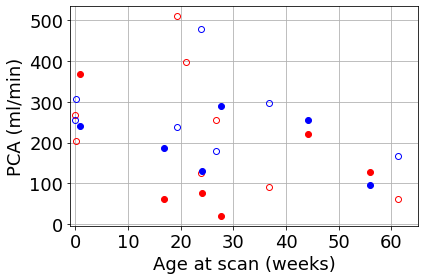

In [18]:
## PCA versus GA. 

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'RPCA']*60, 'ro', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'RPCA']*60, 'ro')

plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'LPCA']*60, 'bo', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'LPCA']*60, 'bo')

plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('PCA (ml/min)', fontsize=18)
# plt.ylim([-20, 300])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

# # Trendline
# T_nan = T.dropna(subset=['SSS']) # This wasn't plotting, becasue of nan in the SSS column
# d = np.polyfit(T_nan['age_at_scan_weeks'], T_nan['SSS_mlmin'], 1)
# f = np.poly1d(d)
# plot_x = [np.min(T_nan['age_at_scan_weeks']), np.max(T_nan['age_at_scan_weeks'])]
# plt.plot(plot_x, f(plot_x), 'k-')

# ax = plt.gca()
# # ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# # for i, x in enumerate(T['SS-MD']):
# #     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['SSS'][i]+0.1)*60))
# for i, x in enumerate(T['ID_N']):
#     if i == 11: # move it down a bit
#         plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]-0.5))
#     elif x == 11 and i == 11:
#         plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]))
#     else:
#         plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]))

# # SSS from Can Wu
# sss_data = pd.read_excel('Vessel Blood Flow Can Wu 2017.xlsx', header=3)
# # plt.plot(52 * sss_data.loc[sss_data['Age [Y]']<1.6, 'Age [Y]'], 60 * sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'], 'kx')
# # plt.xlim([-1, 70])
# plt.ylim([-20, 450])
# ax.axhspan(np.min(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, np.max(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, alpha=0.2, color='black')
        
fig = plt.gcf()
plt.tight_layout()
# fig.savefig('fig_pacaVage.png')

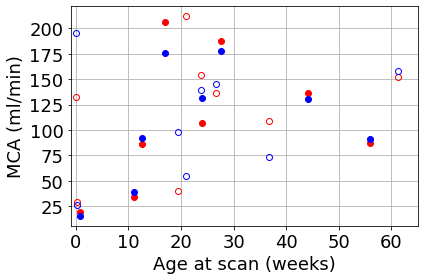

In [19]:
## PCA versus GA. 

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'RMCA']*60, 'ro', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'RMCA']*60, 'ro')

plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'LMCA']*60, 'bo', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'LMCA']*60, 'bo')

plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('MCA (ml/min)', fontsize=18)
# plt.ylim([-20, 300])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

# # Trendline
# T_nan = T.dropna(subset=['SSS']) # This wasn't plotting, becasue of nan in the SSS column
# d = np.polyfit(T_nan['age_at_scan_weeks'], T_nan['SSS_mlmin'], 1)
# f = np.poly1d(d)
# plot_x = [np.min(T_nan['age_at_scan_weeks']), np.max(T_nan['age_at_scan_weeks'])]
# plt.plot(plot_x, f(plot_x), 'k-')

# ax = plt.gca()
# # ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# # for i, x in enumerate(T['SS-MD']):
# #     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['SSS'][i]+0.1)*60))
# for i, x in enumerate(T['ID_N']):
#     if i == 11: # move it down a bit
#         plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]-0.5))
#     elif x == 11 and i == 11:
#         plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]))
#     else:
#         plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]))

# # SSS from Can Wu
# sss_data = pd.read_excel('Vessel Blood Flow Can Wu 2017.xlsx', header=3)
# # plt.plot(52 * sss_data.loc[sss_data['Age [Y]']<1.6, 'Age [Y]'], 60 * sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'], 'kx')
# # plt.xlim([-1, 70])
# plt.ylim([-20, 450])
# ax.axhspan(np.min(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, np.max(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, alpha=0.2, color='black')
        
fig = plt.gcf()
plt.tight_layout()
# fig.savefig('fig_mcaVage.png')

In [21]:
## For Table 2
T['LMCA_mlmin'] = T['LMCA'] * 60
T['RMCA_mlmin'] = T['RMCA'] * 60
T['LPCA_mlmin'] = T['LPCA'] * 60
T['RPCA_mlmin'] = T['RPCA'] * 60

mod = smf.ols(formula="R_PCAMCA ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
mod = smf.ols(formula="R_PCAMCA ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())
mod = smf.ols(formula="L_PCAMCA ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
mod = smf.ols(formula="L_PCAMCA ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())

mod = smf.ols(formula="LMCA_mlmin ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
mod = smf.ols(formula="LMCA_mlmin ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())

mod = smf.ols(formula="RMCA_mlmin ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
mod = smf.ols(formula="RMCA_mlmin ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())

mod = smf.ols(formula="LPCA_mlmin ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
mod = smf.ols(formula="LPCA_mlmin ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())

mod = smf.ols(formula="RPCA_mlmin ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
mod = smf.ols(formula="RPCA_mlmin ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               R_PCAMCA   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     3.996
Date:                Thu, 21 Sep 2023   Prob (F-statistic):             0.0688
Time:                        13:28:39   Log-Likelihood:                -41.185
No. Observations:                  14   AIC:                             86.37
Df Residuals:                      12   BIC:                             87.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.2779      2.27

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-pac